### Load data

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import chain
from collections import Counter

In [3]:
# Load data
train = pd.read_csv('../data/train.csv', index_col='ex_id')
val = pd.read_csv('../data/dev.csv', index_col='ex_id')
test = pd.read_csv('../data/test_no_label.csv', index_col='ex_id')

# Load tokenized data
train_data_tokens = pkl.load(open("../data/tokens/train_data_tokens.pkl", "rb"))
val_data_tokens = pkl.load(open("../data/tokens/val_data_tokens.pkl", "rb"))
test_data_tokens = pkl.load(open("../data/tokens/test_data_tokens.pkl", "rb"))

all_train_tokens = list(chain.from_iterable(train_data_tokens))

# Get labels
y_train = train.label.values
y_val = val.label.values
y_test = test.label.values

In [4]:
# Vocab
def build_vocab(all_tokens, threshold):

    c = Counter(all_tokens)
    vocab = [word for word, count in Counter(all_train_tokens).items() if count >= threshold]
    
    id2token = vocab
    token2id = dict(zip(vocab, range(len(vocab))))
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, 20)

### Count

In [4]:
# # Count Vectorizer
# from sklearn.feature_extraction.text import CountVectorizer

# def dummy(doc):
#     return doc

# count_vec = CountVectorizer(lowercase=False, preprocessor=dummy, tokenizer=dummy, vocabulary=token2id)

# X_train_count = count_vec.fit_transform(train_data_tokens)
# X_val_count = count_vec.transform(val_data_tokens)
# X_test_count = count_vec.transform(test_data_tokens)

### TFIDF

In [5]:
# TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy(doc):
    return doc

tfidf_vec = TfidfVectorizer(lowercase=False, preprocessor=dummy, tokenizer=dummy, vocabulary=token2id)  

X_train_tfidf = tfidf_vec.fit_transform(train_data_tokens)
X_val_tfidf = tfidf_vec.transform(val_data_tokens)
X_test_tfidf = tfidf_vec.transform(test_data_tokens)

### Evaluation

In [11]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import average_precision_score

def evaluate(model, X=X_val_tfidf, y=y_val, print_result=True):
    y_scores = model.predict_proba(X)[:, 1]
    
    auc_score = roc_auc_score(y, y_scores)
    ap_score = average_precision_score(y, y_scores)
    confusion_mx = confusion_matrix(y, model.predict(X))
    if print_result:
        print('Accuracy: ', model.score(X, y))
        print('AUC: ', auc_score)
        print('AP: ', ap_score)
        print('\nConfusion Matrix')
        print(confusion_mx)
    
    return auc_score, ap_score, confusion_mx

---

### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Rough search

In [8]:
cs = [10**n for n in np.arange(-8, 2, dtype=float)]
aucs = []
aps = []

for c in cs:
    lr = LogisticRegression(C=c, max_iter=1000)
    lr.fit(X_train_tfidf, y_train)
    
    auc_score, ap_score, confusion_mx = evaluate(lr, X=X_val_tfidf, y=y_val, print_result=False)
    aucs.append(auc_score)
    aps.append(ap_score)

Text(0.5, 0, 'Log10(c)')

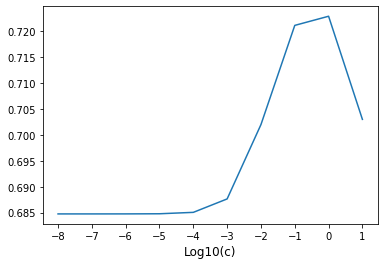

In [12]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(np.log10(cs), aucs)
# plt.plot(np.log10(cs), aps)

# plt.ylim([0.5, 0.9])
plt.xticks(np.log10(cs))
plt.xlabel('Log10(c)',fontsize=12)

Text(0.5, 0, 'Log10(c)')

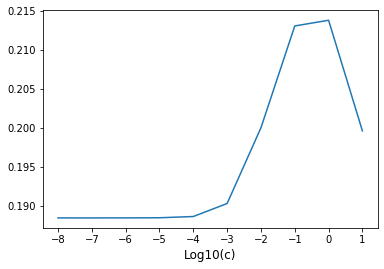

In [11]:
fig = plt.figure()
ax = plt.subplot(111)
# plt.plot(np.log10(cs), aucs)
plt.plot(np.log10(cs), aps)

# plt.ylim([0.5, 0.9])
plt.xticks(np.log10(cs))
plt.xlabel('Log10(c)',fontsize=12)

#### Zoom in

In [29]:
cs = np.linspace(0.01, 10, 13)
aucs = []
aps = []

for c in cs:
    lr = LogisticRegression(C=c, max_iter=1000)
    lr.fit(X_train_tfidf, y_train)
    
    auc_score, ap_score, confusion_mx = evaluate(lr, X=X_val_tfidf, y=y_val, print_result=False)
    aucs.append(auc_score)
    aps.append(ap_score)

Best c is 0.8425, AUC is 0.7235584767572402


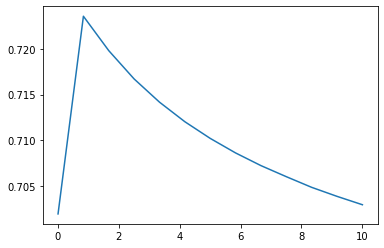

In [50]:
plt.plot(cs, aucs)
print(f'Best c is {cs[aucs.index(max(aucs))]}, AUC is {max(aucs)}')
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subploprint(f'Best c is {cs[aucs.index(max(aucs))]}, AUC is {max(aucs)}')t(111)
plt.plot(cs, aps)
# plt.xticks(cs)
plt.xlabel('c',fontsize=12)

### Further zoom in

In [64]:
cs = np.arange(0.01, 2.0, 0.2)
aucs = []
aps = []

for c in cs:
    lr = LogisticRegression(C=c, max_iter=1000)
    lr.fit(X_train_tfidf, y_train)
    
    auc_score, ap_score, confusion_mx = evaluate(lr, X=X_val_tfidf, y=y_val, print_result=False)
    aucs.append(auc_score)
    aps.append(ap_score)

Best c is 0.41000000000000003, AUC is 0.7250482369494778


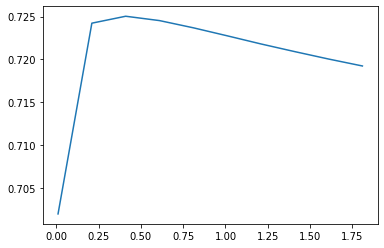

In [65]:
plt.plot(cs, aucs)
print(f'Best c is {cs[aucs.index(max(aucs))]}, AUC is {max(aucs)}')
plt.show()

#### Best c is 0.4

In [9]:
lr = LogisticRegression(C=0.4, max_iter=1000)
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
evaluate(lr, X=X_val_tfidf, y=y_val)

Accuracy:  0.8981012305807673
AUC:  0.7250515498684347
AP:  0.21535622828032727

Confusion Matrix
[[32245    25]
 [ 3635    13]]


(0.7250515498684347,
 0.21535622828032727,
 array([[32245,    25],
        [ 3635,    13]]))

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

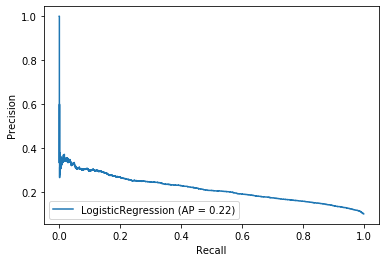

In [15]:
disp = plot_precision_recall_curve(lr, X_val_tfidf, y_val)